### Use of [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform)  to find wind velocity in a glider track log  

Given three consecutive points p0, p1 and p2 of a tracklog of a glider flying in an airmass moving at velocity w at time increments of t<sub>d</sub>, and assuming that the glider flies at a broadly consistent speed during its turns, then w must satisfy the equation:

|p1 - p0 - wt<sub>d</sub>| = |p2 - p1 - wt<sub>d</sub>|

If there is random noise in the measurements of position, we should assign a fitness value to possible values of w to represent its probability field:

F(w) = exp( -b ((p1 - p0 - wt<sub>d</sub>)<sup>2</sup> - (p2 - p1 - wt<sub>d</sub>)<sup>2</sup>)<sup>2</sup> )

And then sum these probability fields for every sequence of three points in a tracklog to find the most likely overall wind direction.

#### Conclusions

The Hough transform can detect the wind direction from a circular track to which 
wind has been applied, but when you add noise you have to counterbalance it 
with a greater spread for the probability field so that the predictions overlap 
enough to reinforce the right answer.

Results are looking promising with these plots, and do seem ready to be turned into 
a library that guess wind vectors that can be plotted.


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy, pandas

td = 2   # 2 second sample rate applied throughout

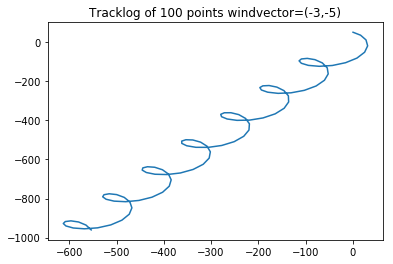

In [4]:
def gentrack(n, wx, wy, degangpersecond, circlerad, sensornoise):
    tlt = numpy.array(range(n))*td
    tlx = numpy.sin(numpy.radians(degangpersecond*tlt))*circlerad + wx*tlt
    tly = numpy.cos(numpy.radians(degangpersecond*tlt))*circlerad + wy*tlt
    if sensornoise:
        tlx += numpy.random.normal(0, numpy.ones(n)*sensornoise)
        tly += numpy.random.normal(0, numpy.ones(n)*sensornoise)
    return tlx, tly

n, wx, wy = 100, -3, -5
degangpersecond, circlerad = 13, 50
tlx, tly = gentrack(n, wx, wy, degangpersecond, circlerad, 0)
plt.plot(tlx, tly)
plt.title("Tracklog of %d points windvector=(%d,%d)" % (n, wx, wy));

In [5]:
# define the grid array of velocities as between -10 and +10m/s
wsx = numpy.linspace(-10, 10, 21)
wsy = numpy.linspace(-10, 10, 21)
td = 2  # seconds between each sample
wxx, wyy = numpy.meshgrid(wsx, wsy)

# with too narrow a band (large houghspread) the single point sample in each cell is not 
# representative of the overall value that should be assigned to the cell
def F(p0x, p0y, p1x, p1y, p2x, p2y, houghspread, wxx, wyy):
    D = numpy.exp(-houghspread*(((p1x - p0x - wxx*td)**2 + (p1y - p0y - wyy*td)**2) - 
                                ((p2x - p1x - wxx*td)**2 + (p2y - p1y - wyy*td)**2))**2)
    return D / sum(sum(D))


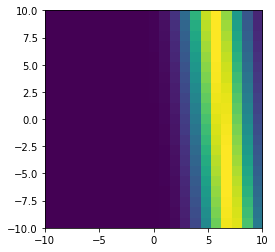

In [6]:
# example showing of the probability field
houghspread = 0.0002
Hextents = [wsx[0], wsx[-1], wsy[0], wsy[-1]]
D = F(0, 0, 10, 0, 26.4, 0.5, houghspread, wxx, wyy)
plt.imshow(D, origin='lower', extent=Hextents)

Peak value -3.0 -5.0 should match -3 -5


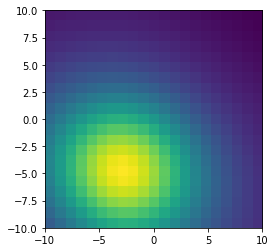

In [7]:
# sum these probability fields for sets of three points in the tracklog
def houghtrack(tlx, tly, houghspread):
    H = numpy.zeros((len(wsx), len(wsy)))
    for i in range(2, len(tlx)):
        H += F(tlx[i-2], tly[i-2], tlx[i-1], tly[i-1], tlx[i], tly[i], 
               houghspread, wxx, wyy)
    return H

H = houghtrack(tlx, tly, houghspread*0.1)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
print("Peak value", wsx[ix], wsy[iy], "should match", wx, wy)


In [11]:
# Put this together to print a table of detected wind offsets from inputs
import pandas  # use this for plotting the table 
def tabwindestimates(n, wdx, wdy, angpersecond, circlerad, houghspread, sensornoise):
    rows = [ ]
    for wx, wy in zip(wdx, wdy):
        tlx, tly = gentrack(n, wx, wy, angpersecond, circlerad, sensornoise)
        H = houghtrack(tlx, tly, houghspread)
        iy, ix = numpy.unravel_index(H.argmax(), H.shape)
        rows.append((wx, wy, wsx[ix], wsy[iy]))
    df = pandas.DataFrame.from_records(rows, columns=["wx", "wy", "whx", "why"])
    df["err"] = numpy.hypot(df.wx-df.whx, df.wy-df.why)
    return df

# print a table showing the error estimates
wdx, wdy = numpy.meshgrid(numpy.linspace(-7, 7, 4), numpy.linspace(-1, 6, 4))
wdx, wdy = numpy.ravel(wdx), numpy.ravel(wdy)

print("Wind estimates when no noise added to the positions is good")
tabwindestimates(100, wdx, wdy, degangpersecond, circlerad, houghspread, 0)


Wind estimates when no noise added to the positions is good


,wx,wy,whx,why,err
0,-7.000000,-1.000000,-7.0,-1.0,0.000000
1,-2.333333,-1.000000,-2.0,-1.0,0.333333
2,2.333333,-1.000000,2.0,-1.0,0.333333
3,7.000000,-1.000000,7.0,-1.0,0.000000
4,-7.000000,1.333333,-7.0,1.0,0.333333
5,-2.333333,1.333333,-2.0,1.0,0.471405
6,2.333333,1.333333,2.0,1.0,0.471405
7,7.000000,1.333333,7.0,1.0,0.333333
8,-7.000000,3.666667,-7.0,4.0,0.333333
9,-2.333333,3.666667,-2.0,4.0,0.471405


In [14]:
# Then when you add sensor noise of std 1.8m (the resolution of the IGC 
# representation of the GPS track positions) the estimates are terrible
wdx, wdy = numpy.meshgrid(numpy.linspace(-7, 7, 4), numpy.linspace(-1, 6, 4))
wdx, wdy = numpy.ravel(wdx), numpy.ravel(wdy)
print("Wind estimates with noise added is very bad")
tabwindestimates(100, wdx, wdy, degangpersecond, circlerad, 0.00001, 1.8)


Wind estimates with noise added is very bad


,wx,wy,whx,why,err
0,-7.000000,-1.000000,-10.0,1.0,3.605551
1,-2.333333,-1.000000,-3.0,-1.0,0.666667
2,2.333333,-1.000000,3.0,-3.0,2.108185
3,7.000000,-1.000000,7.0,0.0,1.000000
4,-7.000000,1.333333,-9.0,2.0,2.108185
5,-2.333333,1.333333,-3.0,2.0,0.942809
6,2.333333,1.333333,2.0,2.0,0.745356
7,7.000000,1.333333,10.0,2.0,3.073181
8,-7.000000,3.666667,-10.0,10.0,7.007932
9,-2.333333,3.666667,-4.0,5.0,2.134375


In [18]:
circlerad

50

The peak should be at 2 3


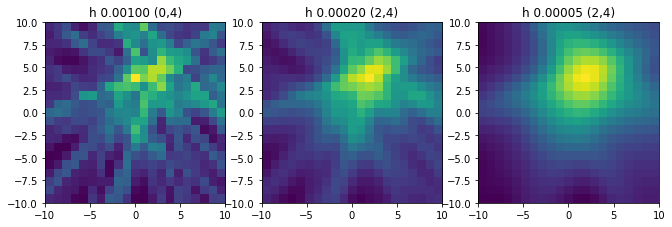

In [24]:
# With a small value of houghspread (ie lots of spreading) you can get one peak 
# in the right place
n, wx, wy = 40, 2, 3
circlerad = 50
tlx, tly = gentrack(n, wx, wy, degangpersecond, circlerad, 1.2)
plt.figure(figsize=(11,5))
for s, houghspread in enumerate([0.001, 0.0002, 0.00005]):
    plt.subplot(131+s)
    H = houghtrack(tlx, tly, houghspread)
    plt.imshow(H, origin='lower', extent=Hextents)
    iy, ix = numpy.unravel_index(H.argmax(), H.shape)
    plt.title("h %.05f (%d,%d)" % (houghspread, wsx[ix], wsy[iy]))
print("The peak should be at", wx, wy)


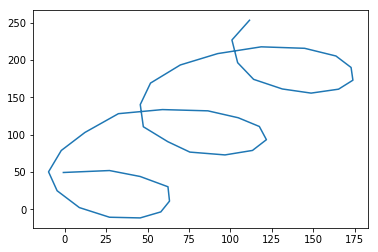

In [25]:
plt.plot(tlx, tly);

#### Real data examples

The file shortzerowind.csv is 200seconds (100 samples) in XY format has had the 
wind drift subtracted by eye, and has all turns in the same right hand direction.

We add wind values to it to see if the Hough transform can extract it back out.

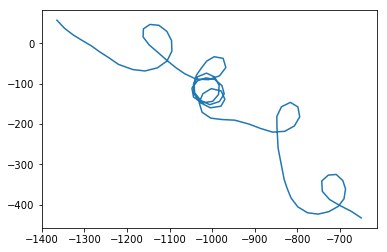

In [41]:
df = pandas.read_csv("../sampledata/shortzerowind.csv")
stlx, stly = df.x, df.y
tlt = numpy.array(range(len(tlx)))*td
plt.plot(stlx, stly);

should be 3 -6


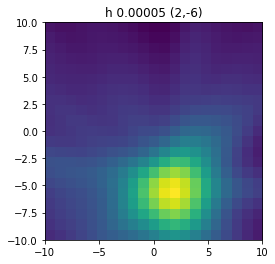

In [52]:
wx, wy = 3, -6   # try changing and rerunning this
tlx = stlx + tlt*wx
tly = stly + tlt*wy
H = houghtrack(tlx, tly, houghspread=0.00005)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
plt.title("h %.05f (%d,%d)" % (houghspread, wsx[ix], wsy[iy]));
print("should be", wx, wy)

#### Try with big data

We have a 4 hour flight in Slovenia along a ridge in IGC format
/home/julian/hgstuff/HGnotebooks/sampledata/sloveniananos.igc


In [59]:
numpy.array(pQ.x)



array([   185.77509734,    185.77509734,    184.48499249, ...,
        12263.73663389,  12263.73663389,  12263.73663389])

8341 samples


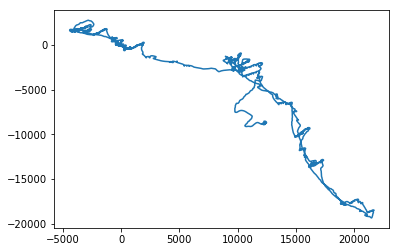

In [208]:
from flightjy import utils, loaders
fname = "../sampledata/sloveniananos.igc"
#fname = "../../2018-03-13-logs/822B0912.IGC"
#fname = "../../2018-03-13-logs/83DB0912.IGC"

pQ, h = loaders.GLoadIGC(fname)
loaders.processQaddrelEN(pQ)
ftlx, ftly = numpy.array(pQ.x), numpy.array(pQ.y)
falt = numpy.array(pQ.altb)
plt.plot(ftlx, ftly);
print(len(ftlx), "samples")

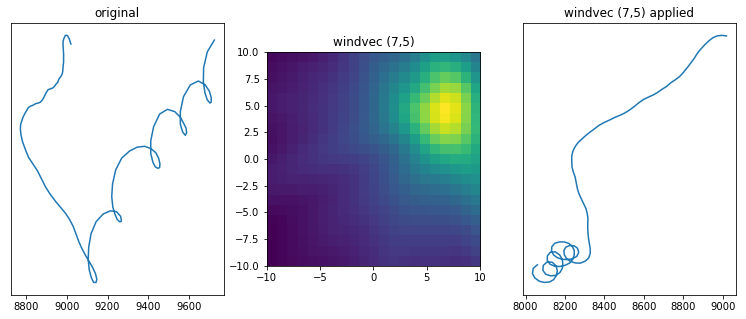

In [209]:
# Experiments here with different sets of 
i0, i1 = 1000, 1100
i0, i1 = 3000, 3100
i0, i1 = 4300, 4550
i0, i1 = 6800, 6920

tlx, tly = ftlx[i0:i1], ftly[i0:i1]
H = houghtrack(tlx, tly, houghspread=0.00005)

plt.figure(figsize=(13,5))

plt.subplot(131)
plt.plot(tlx, tly);
plt.title("original");
plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(132)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
wx, wy = wsx[ix], wsy[iy]
plt.title("windvec (%d,%d)" % (wx, wy));

plt.subplot(133)
tlt = numpy.array(range(len(tlx)))*td
plt.plot(tlx - tlt*wx, tly - tlt*wy);
plt.title("windvec (%d,%d) applied" % (wx, wy));
plt.gca().axes.get_yaxis().set_visible(False)


In [210]:
# Now we step through and plot wind directions on sequences of 100 points at 
# different altitudes (the worst estimates are on gliding sections)

windests = [ ]
for i in range(100, len(ftly)-50, 50):
    i0, i1 = i-50, i+50
    tlx, tly = ftlx[i0:i1], ftly[i0:i1]
    H = houghtrack(tlx, tly, houghspread=0.00005)
    iy, ix = numpy.unravel_index(H.argmax(), H.shape)
    wx, wy = wsx[ix], wsy[iy]
    windests.append((i0, i1, wx, wy))


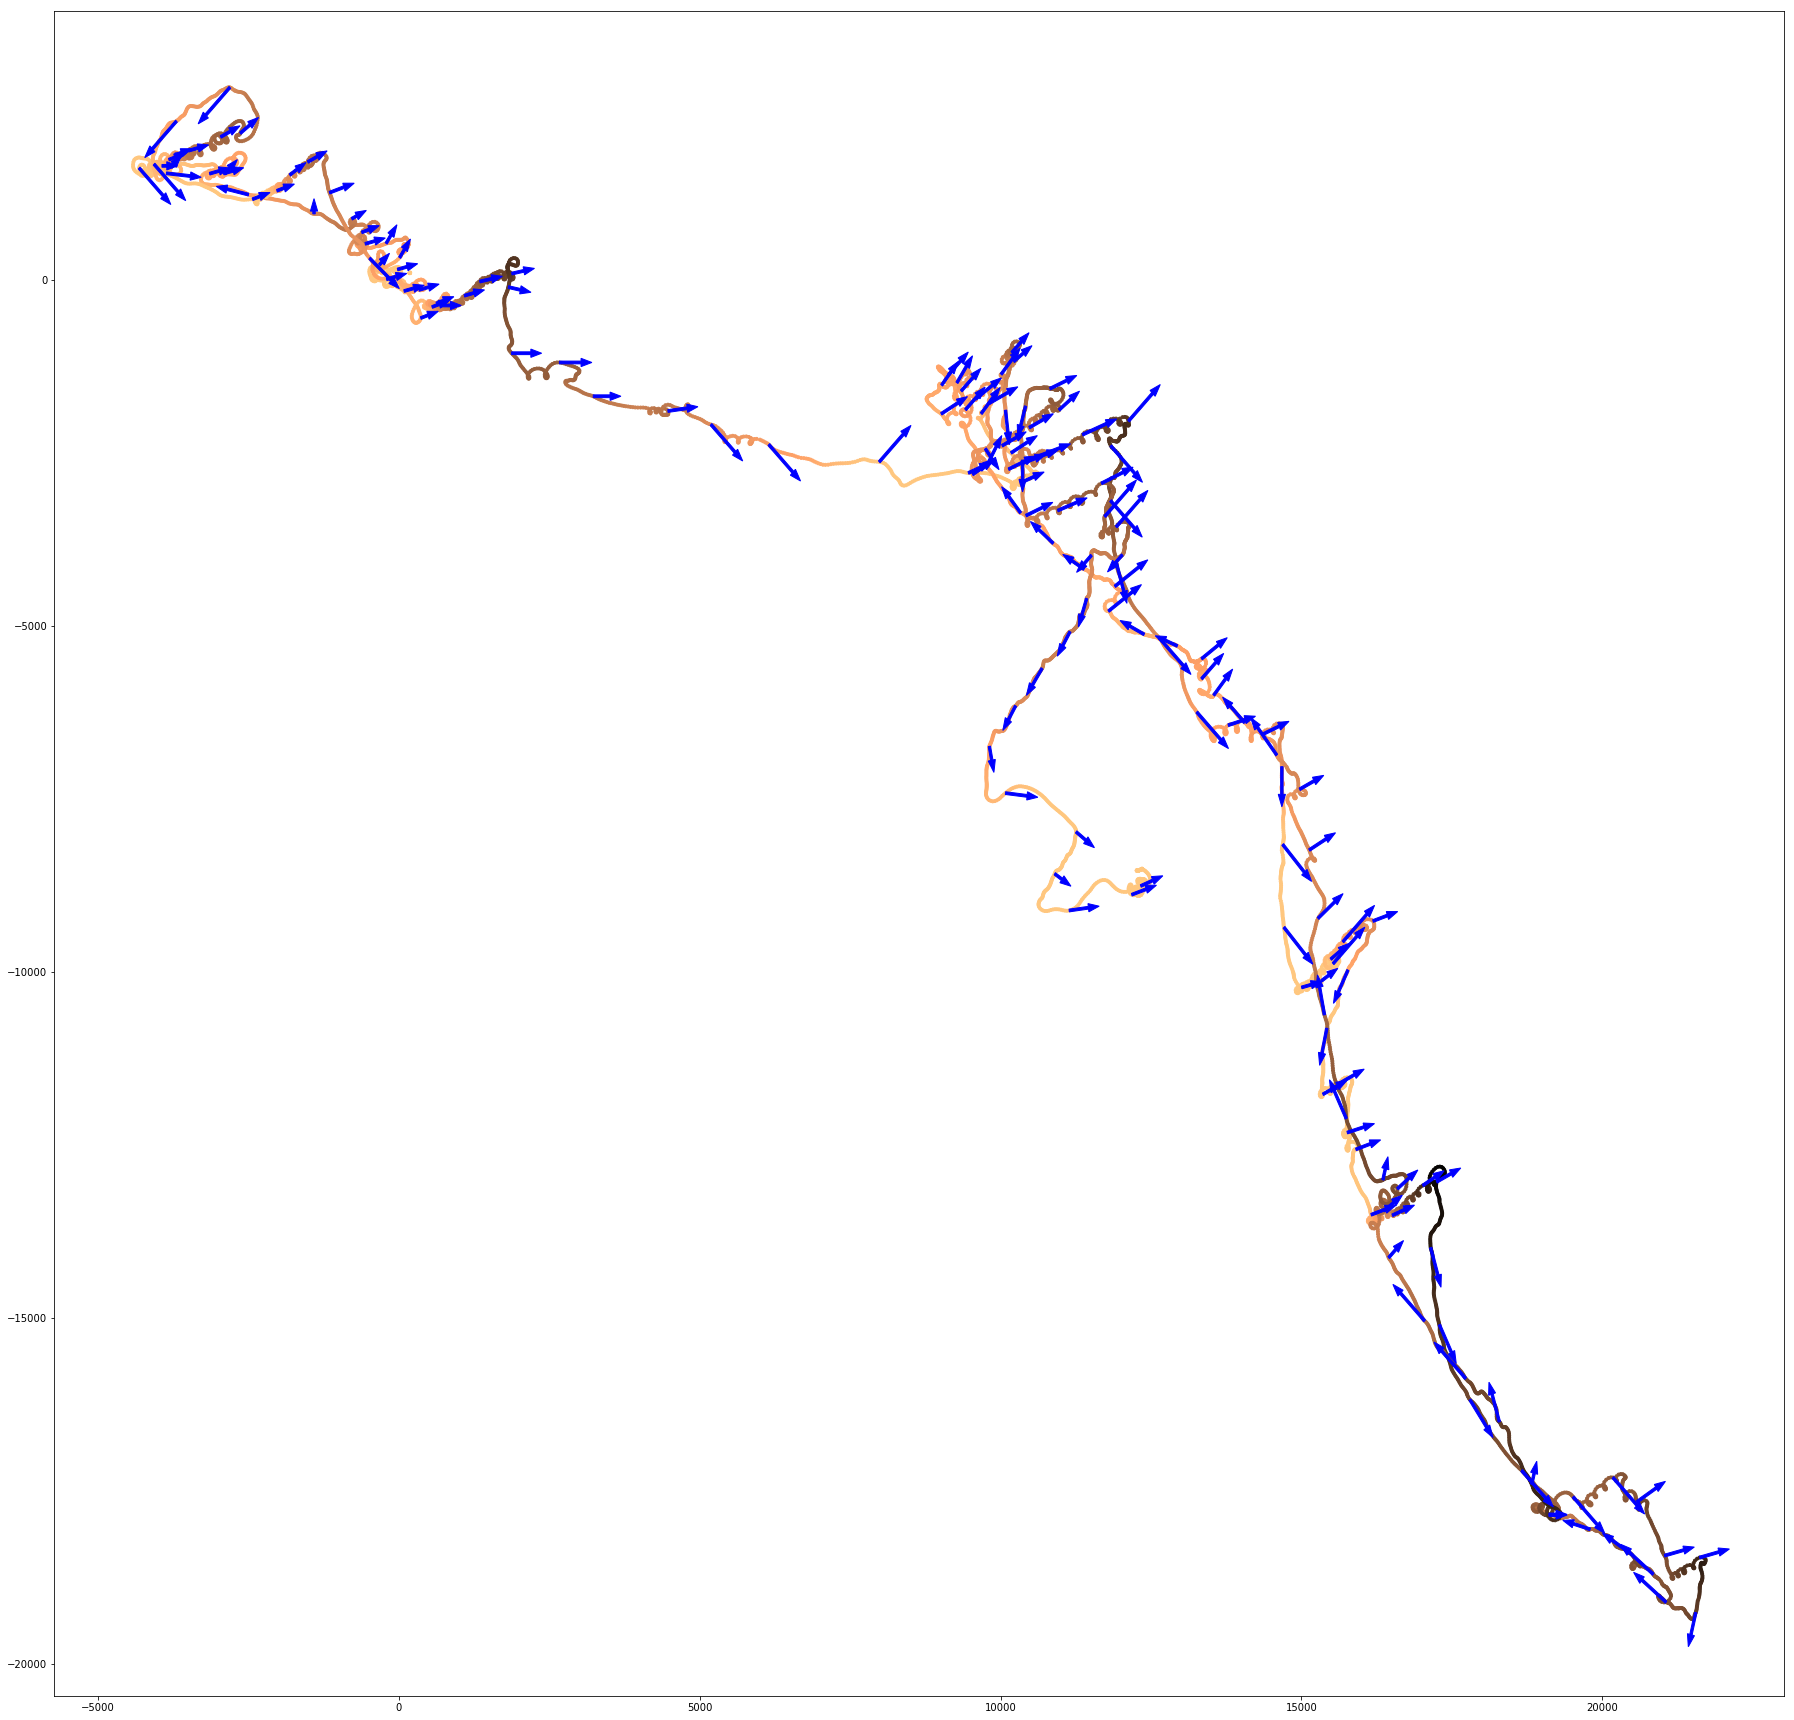

In [211]:

cmap = plt.get_cmap("copper")
plt.figure(figsize=(31,31))
#plt.plot(ftlx, ftly, color="black")
plt.scatter(ftlx, ftly, c=-numpy.maximum(1000, falt), cmap=cmap, marker=".")

arrowlengfac = 40
for i0, i1, wx, wy in windests:
    im = int((i0+i1)/2)
    tlx, tly = ftlx[i0:i1], ftly[i0:i1]
    az = falt[i0:i1].mean()
    ax, ay = ftlx[im], ftly[im]
    plt.arrow(ax, ay, wx*arrowlengfac, wy*arrowlengfac, 
              width=arrowlengfac, color="b")
#plt.savefig("pic.png")


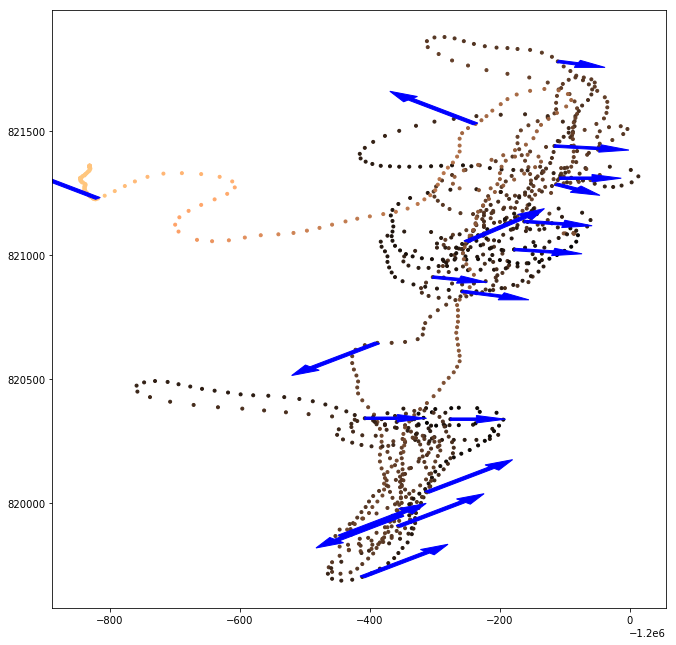

In [201]:

cmap = plt.get_cmap("copper")
plt.figure(figsize=(11,11))
#plt.plot(ftlx, ftly, color="black")
plt.scatter(ftlx, ftly, c=-falt, cmap=cmap, marker=".")

arrowlengfac = 10
for i0, i1, wx, wy in windests:
    im = int((i0+i1)/2)
    tlx, tly = ftlx[i0:i1], ftly[i0:i1]
    az = falt[i0:i1].mean()
    ax, ay = ftlx[im], ftly[im]
    plt.arrow(ax, ay, wx*arrowlengfac, wy*arrowlengfac, 
              width=arrowlengfac, color="b")
#plt.savefig("pic.png")
